In [2]:
# Import libraries and set desired options
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
# !pip install eli5
import eli5
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display_html

In [3]:
SEED = 17

In [4]:
# Helper functions

# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [36]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

train = pd.read_csv('../../data/train_sessions.csv', parse_dates = times, index_col='session_id')
test = pd.read_csv('../../data/test_sessions.csv', parse_dates = times, index_col='session_id')

train.sort_values(by='time1', inplace=True)

y_train = train['target'].astype('int').values

train_test_idx = train.shape[0]
data = pd.concat([train, test], sort=False) # leave train.target for eda

train.shape, test.shape, data.shape

((253561, 21), (82797, 20), (336358, 21))

# TF-IDF

In [37]:
with open('../../data/site_dic.pkl', 'rb') as f:
    site2id = pickle.load(f)
# create an inverse id _> site mapping
id2site = {v:k for (k, v) in site2id.items()}
# we treat site with id 0 as "unknown"
id2site[0] = 'unknown'

In [38]:
data[sites] = data[sites].fillna(0).astype(np.uint16)
data['words'] = data[sites].astype(np.str).apply(' '.join, axis=1)
#data['words'] = data[sites].astype('int').apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1)

#words = CountVectorizer(max_features=50000, ngram_range=(1, 3)).fit_transform(data['words'])
# vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), tokenizer = lambda s: s.split())
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
sites_tf_idf = vectorizer.fit_transform(data['words'])

data.drop(['words'], inplace=True, axis=1)
sites_feature_names = vectorizer.get_feature_names()

In [39]:
X_train = sites_tf_idf[:train_test_idx]
X_test = sites_tf_idf[train_test_idx:]

In [40]:
time_split = TimeSeriesSplit(n_splits=6)
logit = LogisticRegression(C=1, random_state=SEED, solver='liblinear')

In [41]:
def train_and_predict(model, X_train, y_train, X_test, site_feature_names=sites_feature_names, 
                      new_feature_names=None, cv=time_split, scoring='roc_auc',
                      top_n_features_to_show=30, submission_file_name='submission.csv'):
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, 
                            scoring=scoring, n_jobs=-1)
    print('CV scores', cv_scores)
    print('CV mean: {}, CV std: {}'.format(cv_scores.mean(), cv_scores.std()))
    model.fit(X_train, y_train)
    
    if new_feature_names:
        all_feature_names = site_feature_names + new_feature_names 
    else: 
        all_feature_names = site_feature_names
    
    display_html(eli5.show_weights(estimator=model, 
                  feature_names=all_feature_names, top=top_n_features_to_show))
    
    if new_feature_names:
        print('New feature weights:')
    
        print(pd.DataFrame({'feature': new_feature_names, 
                        'coef': model.coef_.flatten()[-len(new_feature_names):]}))
    
    test_pred = model.predict_proba(X_test)[:, 1]
    write_to_submission_file(test_pred, submission_file_name) 
    
    return cv_scores

In [42]:
cv_scores1 = train_and_predict(model=logit, X_train=X_train, y_train=y_train, 
                  X_test=X_test, site_feature_names=sites_feature_names,              
                  cv=time_split, submission_file_name='subm1.csv')

CV scores [0.65698018 0.8760302  0.84681886 0.89822155 0.87995211 0.92729289]
CV mean: 0.8475492985558003, CV std: 0.08860487689447613


Weight?,Feature
+6.291,27190
+6.072,12619
+5.427,3000
+5.265,27307
+4.789,7832
+4.620,27189
+4.269,704
+4.201,2078
+4.192,27174
+4.018,27336


**Let's create a separate function to add new features (this will keep the code cleaner). To demonstrate possible overfitting, we'll keep a flag - whether to add an `hour` feature or not.**

In [22]:
data['min'] = data[times].min(axis=1)
data['max'] = data[times].max(axis=1)
data['seconds'] = ((data['max'] - data['min']) / np.timedelta64(1, 's'))
data['seconds_log']=np.log1p(data['seconds'])
data['minutes'] = ((data['max'] - data['min']) / np.timedelta64(1, 'm')).round(2)
data.drop(['min','max'], inplace=True, axis=1)

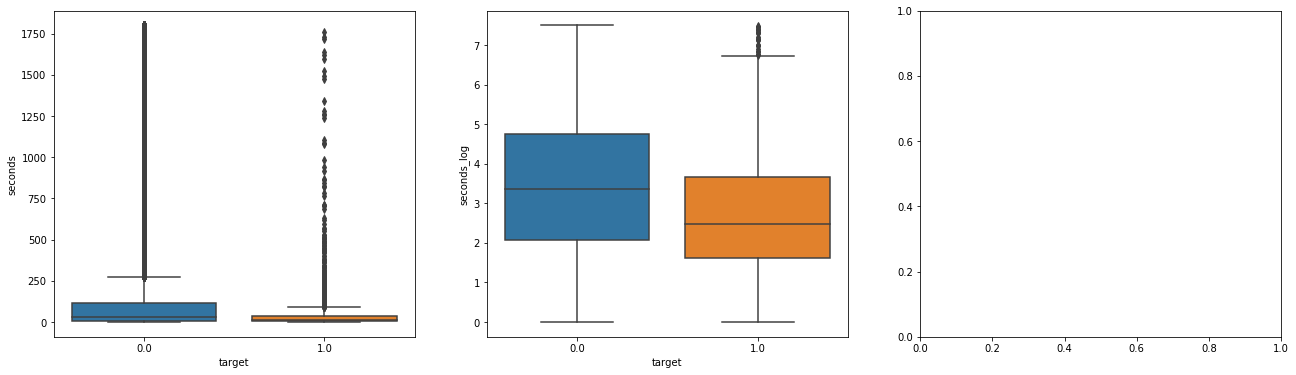

In [24]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
sns.boxplot(x='target', y='seconds', data=data[:train_test_idx], ax=axes[0])
sns.boxplot(x='target', y='seconds_log', data=data[:train_test_idx], ax=axes[1])

In [43]:
data['min'] = data[times].min(axis=1)
data['max'] = data[times].max(axis=1)
data['seconds'] = ((data['max'] - data['min']) / np.timedelta64(1, 's'))
data['seconds_log']=np.log1p(data['seconds'])
data['minutes'] = ((data['max'] - data['min']) / np.timedelta64(1, 'm')).round(2)
data.drop(['min','max'], inplace=True, axis=1)

data['month'] = data['time1'].apply(lambda ts: ts.month+(12*(ts.year-2013))).astype(np.int8)
data['yyyymm'] = data['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32)
data['mm'] = data['time1'].apply(lambda ts: ts.month).astype(np.int8)
data['yyyy'] = data['time1'].apply(lambda ts: ts.year).astype(np.int8)

data['dayofweek'] = data['time1'].apply(lambda ts: ts.dayofweek).astype(np.int8)
data['weekend'] = data['time1'].apply(lambda ts: ts.dayofweek > 5).astype(np.int8)

data['hour'] = data['time1'].apply(lambda ts: ts.hour).astype(np.int8)
data['morning'] = ((data.hour >= 7) & (data.hour <= 11)).astype('int').values.reshape(-1, 1)
data['day'] = ((data.hour >= 12) & (data.hour <= 18)).astype('int').values.reshape(-1, 1)
data['evening'] = ((data.hour >= 19) & (data.hour <= 23)).astype('int').values.reshape(-1, 1)
data['night'] = ((data.hour >= 0) & (data.hour <=6)).astype('int').values.reshape(-1, 1)

data['max_hour'] = data[times].max(axis=1).apply(lambda ts: ts.hour)
data['max_morning'] = ((data.max_hour >= 7) & (data.max_hour <= 11)).astype('int').values.reshape(-1, 1)
data['max_day'] = ((data.max_hour >= 12) & (data.max_hour <= 18)).astype('int').values.reshape(-1, 1)
data['max_evening'] = ((data.max_hour >= 19) & (data.max_hour <= 23)).astype('int').values.reshape(-1, 1)
data['max_night'] = ((data.max_hour >= 0) & (data.max_hour <=6)).astype('int').values.reshape(-1, 1)

data['short'] = data['minutes'].map(lambda x: x < 0.8).astype(np.int8)
data['long'] = data['minutes'].map(lambda x: x >= 0.8).astype(np.int8)

data["online_day"] = data['time1'].apply(lambda ts: ts.dayofweek in [0,1,3,4]).astype(np.int8)
data["mon"] = data['time1'].apply(lambda ts: ts.dayofweek in [0]).astype(np.int8) # monday
data["wen"] = data['time1'].apply(lambda ts: ts.dayofweek in [2]).astype(np.int8) # wensday
data["sun"] = data['time1'].apply(lambda ts: ts.dayofweek in [6]).astype(np.int8) # sunday

In [44]:
hosts = pd.read_pickle('../../data/site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
data = pd.merge(data, hosts, how='left', on='site1')

In [45]:
data['big_site'] = data['len'].apply(lambda x: x > 5).astype(np.int8)
data['typical_site'] = data['len'].apply(lambda x: x == 3).astype(np.int8)

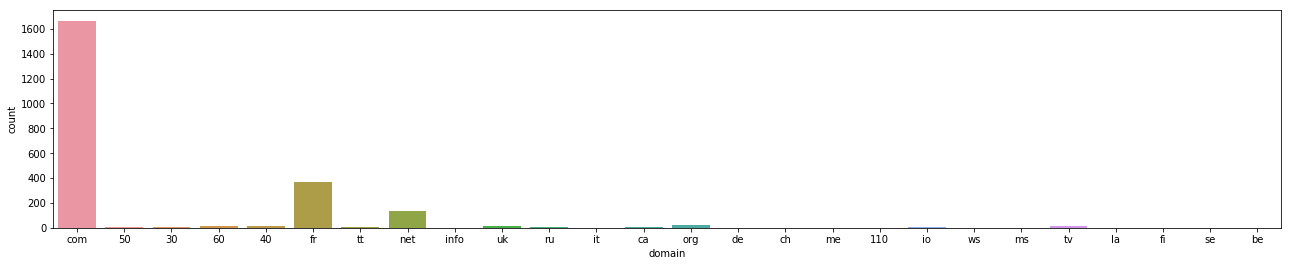

In [46]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,4))
sns.countplot(x="domain", data=data[data.target==1][:train_test_idx], ax=axes); # Alice

In [47]:
data['typical_domain'] = data['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

In [48]:
data.drop(times + sites + ['target'], inplace=True, axis=1)
data.to_pickle('dump.pkl')
data.columns

Index(['seconds', 'seconds_log', 'minutes', 'month', 'yyyymm', 'mm', 'yyyy',
       'dayofweek', 'weekend', 'hour', 'morning', 'day', 'evening', 'night',
       'max_hour', 'max_morning', 'max_day', 'max_evening', 'max_night',
       'short', 'long', 'online_day', 'mon', 'wen', 'sun', 'len', 'domain',
       'big_site', 'typical_site', 'typical_domain'],
      dtype='object')

In [49]:
data.columns

Index(['seconds', 'seconds_log', 'minutes', 'month', 'yyyymm', 'mm', 'yyyy',
       'dayofweek', 'weekend', 'hour', 'morning', 'day', 'evening', 'night',
       'max_hour', 'max_morning', 'max_day', 'max_evening', 'max_night',
       'short', 'long', 'online_day', 'mon', 'wen', 'sun', 'len', 'domain',
       'big_site', 'typical_site', 'typical_domain'],
      dtype='object')

In [62]:
data = pd.read_pickle('dump.pkl')

# commented columns go to model
data.drop([
    'seconds', 
    #'seconds_log',
    'minutes', 
    'month', 
    #'yyyymm', 
    'mm', 
    'yyyy', 
    #'dayofweek',
    #'weekend', 
    'hour', 
    #'len', 
    #'domain', 
    #'short', 
    #'long',
    'online_day',
    #'mon',
    #'wen',
    #'sun',
    #'morning', 
    #'day', 
    #'evening', 
    #'night', 
    'max_hour', 
    #'max_morning', 
    #'max_day', 
    #'max_evening', 
    #'max_night', 
    #'big_site',
    'typical_site',
    #'typical_domain',
], inplace=True, axis=1)

data = pd.get_dummies(data, columns=[
    #'yyyy',
    #'mm',
    'domain',
    'dayofweek',
    #'hour',
    #'len'
])

features_to_scale = [
    #'seconds',
    'seconds_log',
    #'minutes',
    #'month',
    'yyyymm',
    #'dayofweek',
    #'hour',
    #'len',
]
data[features_to_scale] = StandardScaler().fit_transform(data[features_to_scale])

C:\Users\sepolt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sepolt\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [63]:
list(data.columns.values)

['seconds_log',
 'yyyymm',
 'weekend',
 'morning',
 'day',
 'evening',
 'night',
 'max_morning',
 'max_day',
 'max_evening',
 'max_night',
 'short',
 'long',
 'mon',
 'wen',
 'sun',
 'len',
 'big_site',
 'typical_domain',
 'domain_102',
 'domain_107',
 'domain_110',
 'domain_114',
 'domain_118',
 'domain_12',
 'domain_13',
 'domain_133',
 'domain_145',
 'domain_164',
 'domain_191',
 'domain_193',
 'domain_194',
 'domain_195',
 'domain_2',
 'domain_204',
 'domain_206',
 'domain_208',
 'domain_21',
 'domain_211',
 'domain_213',
 'domain_22',
 'domain_222',
 'domain_228',
 'domain_26',
 'domain_30',
 'domain_4',
 'domain_40',
 'domain_48',
 'domain_50',
 'domain_6',
 'domain_60',
 'domain_70',
 'domain_82',
 'domain_85',
 'domain_9',
 'domain_ad',
 'domain_ag',
 'domain_am',
 'domain_ar',
 'domain_asia',
 'domain_at',
 'domain_au',
 'domain_be',
 'domain_bi',
 'domain_biz',
 'domain_bj',
 'domain_br',
 'domain_by',
 'domain_bz',
 'domain_ca',
 'domain_cat',
 'domain_cc',
 'domain_cd',
 'd

In [64]:
X_train = csr_matrix(hstack([sites_tf_idf[:train_test_idx], data[:train_test_idx]]))
X_test = csr_matrix(hstack([sites_tf_idf[train_test_idx:], data[train_test_idx:]]))
X_train.shape, X_test.shape

((253561, 50191), (82797, 50191))

In [65]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train, y_train=y_train, 
                               X_test=X_test, 
                               site_feature_names=sites_feature_names,
                               new_feature_names=list(data.columns.values),
                               cv=time_split, submission_file_name='submission.csv')

CV scores [0.79722523 0.88420524 0.93537086 0.96338714 0.96758635 0.91625657]
CV mean: 0.9106718963603447, CV std: 0.0580660676530949


Weight?,Feature
+5.738,27190
+5.298,12619
+5.113,3000
+4.847,27174
+4.637,7832
+4.473,704
+4.469,2078
+4.203,27307
+4.001,27189
+3.726,77


New feature weights:
            feature      coef
0       seconds_log -0.061027
1            yyyymm -0.407248
2           weekend -1.265467
3           morning -1.295203
4               day -0.270381
5           evening -1.809528
6             night  0.000000
7       max_morning -2.147548
8           max_day  0.624615
9       max_evening -1.852179
10        max_night  0.000000
11            short -1.539564
12             long -1.835548
13              mon  0.534439
14              wen -1.347959
15              sun -1.265467
16              len -0.124010
17         big_site -0.463709
18   typical_domain  0.260524
19       domain_102 -0.000402
20       domain_107 -0.000066
21       domain_110  0.494019
22       domain_114 -0.000251
23       domain_118 -0.066228
24        domain_12 -0.000308
25        domain_13 -0.007837
26       domain_133 -0.000066
27       domain_145 -0.000190
28       domain_164 -0.000081
29       domain_191 -0.000222
..              ...       ...
161       domain_sn

In [22]:
params = {
    'C': np.logspace(-2, 2, 20),
    'penalty': ['l1','l2']
}

grid = GridSearchCV(estimator=logit, param_grid=params, scoring='roc_auc', cv=time_split, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

grid.best_estimator_, grid.best_score_, grid.best_params_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 16.1min finished


(LogisticRegression(C=5.455594781168514, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2', random_state=17,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 0.9298890100201885,
 {'C': 5.455594781168514, 'penalty': 'l2'})

In [23]:
cv_scores2 = train_and_predict(model=grid.best_estimator_, X_train=X_train, y_train=y_train, 
                               X_test=X_test, 
                               site_feature_names=sites_feature_names,
                               new_feature_names=list(data.columns.values),
                               cv=time_split, submission_file_name='submission.csv')

CV scores [0.89092213 0.96474653 0.93399837]
CV mean: 0.9298890100201884, CV std: 0.030278438966432227


Weight?,Feature
+11.274,27174
+11.029,27190
+8.471,11812
+8.059,7494
+7.589,27362
+7.040,27359
+7.010,27269
+6.746,27298
+6.737,27168
+6.632,27348


New feature weights:
            feature      coef
0           seconds -0.061229
1           minutes -0.078881
2            yyyymm -0.518483
3           weekend -1.500892
4           morning -1.012074
5               day -0.674754
6           evening -2.464017
7             night  0.000000
8       max_morning -2.688165
9           max_day  1.042739
10      max_evening -2.505419
11        max_night  0.000000
12            short -1.975522
13             long -2.175323
14              mon  0.531239
15              wen -1.526620
16              sun -1.500892
17              len -0.138851
18         big_site -0.823795
19   typical_domain  0.521637
20       domain_102 -0.000398
21       domain_107 -0.000072
22       domain_110  0.513416
23       domain_114 -0.000305
24       domain_118 -0.083781
25        domain_12 -0.000306
26        domain_13 -0.010310
27       domain_133 -0.000085
28       domain_145 -0.000191
29       domain_164 -0.000075
..              ...       ...
162       domain_sn

In [ ]:
def add_time_features(times, X_sparse, add_hour=True):
    hour = times['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int').values.reshape(-1, 1)
    day = ((hour >= 12) & (hour <= 18)).astype('int').values.reshape(-1, 1)
    evening = ((hour >= 19) & (hour <= 23)).astype('int').values.reshape(-1, 1)
    night = ((hour >= 0) & (hour <=6)).astype('int').values.reshape(-1, 1)
    
    max_hour = times.max(axis=1).apply(lambda ts: ts.hour)
    max_morning = ((max_hour >= 7) & (max_hour <= 11)).astype('int').values.reshape(-1, 1)
    max_day = ((max_hour >= 12) & (max_hour <= 18)).astype('int').values.reshape(-1, 1)
    max_evening = ((max_hour >= 19) & (max_hour <= 23)).astype('int').values.reshape(-1, 1)
    max_night = ((max_hour >= 0) & (max_hour <=6)).astype('int').values.reshape(-1, 1)
    
    objects_to_hstack = [X_sparse, morning, day, evening, night, max_morning, max_day, max_evening, max_night]
    feature_names = ['morning', 'day', 'evening', 'night', 'max_morning', 'max_day', 'max_evening', 'max_night']
    
    if add_hour:
        # we'll do it right and scale hour dividing by 24
        objects_to_hstack.append(hour.values.reshape(-1, 1) / 24)
        feature_names.append('hour')
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [ ]:
%%time
X_train_with_times1, new_feat_names = add_time_features(train_times, X_train_sites)
X_test_with_times1, _ = add_time_features(test_times, X_test_sites)

In [ ]:
X_train_with_times1.shape, X_test_with_times1.shape

**Performing time series cross-validation, we see an improvement in ROC AUC.**

In [40]:
cv_scores2 = train_and_predict(model=logit, X_train=X_train, y_train=y_train, 
                               X_test=X_test_with_times1, 
                               site_feature_names=sites_feature_names,
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm2.csv')

NameError: name 'X_test_with_times1' is not defined

**We see an improvement almost for all folds as compared to the results of previous cross-validation.**

In [ ]:
cv_scores2 > cv_scores1

## Submission 3: Example of overfitting

**Making a new submission, we notice a leaderboard score improvement as well (0.91807 ->  0.93089). Looks good as compared to sites only. But we might be a bit wary that feature `hour` gets such a big weight. Let's try the same features but without `hour`.**

In [ ]:
%%time
X_train_with_times2, new_feat_names = add_time_features(train_times, X_train_sites, add_hour=False)
X_test_with_times2, _ = add_time_features(test_times, X_test_sites, add_hour=False)


cv_scores3 = train_and_predict(model=logit, X_train=X_train_with_times2, y_train=y_train, 
                               X_test=X_test_with_times2, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names,
                               cv=time_split, submission_file_name='subm3.csv')

**Now cross-validation is much more stable. 3rd CV results are better for each and every fold as compared to the first ones. And actually the situation is better than with the `hour` feature for 5 folds out of 10, but in such case we'll prefer a model with less variation of CV results, i.e. the last one.**

In [ ]:
cv_scores3 > cv_scores1

In [ ]:
cv_scores3 > cv_scores2

Making a new submission we get... Wow! **0.94535** Public LB score instead of **0.93089** when adding the `hour` feature. We were right, the `hour` feature leads to overfitting, and it's better not to add it. 

## Submissions 4 and 5: The importance of feature scaling

**Now we'll add a new feature: session duration. But beware: first we'll do it in an incorrect way, then we'll correct ourselves.**

In [ ]:
def add_session_duration_incorrect(times, X_sparse):
    new_feat = (times.max(axis=1) - times.min(axis=1)).astype('timedelta64[ms]').astype(int)
    return hstack([X_sparse, new_feat.values.reshape(-1, 1)])

In [ ]:
X_train_with_time_incorrect = add_session_duration_incorrect(train_times, X_train_with_times2)
X_test_with_time_incorrect = add_session_duration_incorrect(test_times, X_test_with_times2)

In [ ]:
cv_scores4 = train_and_predict(model=logit, X_train=X_train_with_time_incorrect, y_train=y_train, 
                               X_test=X_test_with_time_incorrect, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm4.csv')

**What's the reason of such a deterioration?**
Obvious! The new feature is session duration in milliseconds, it's maximal value is very high (check it). We need to either scale a new feature or, alternatively, measure it in some different units. You can check that actually, measuring it in seconds (rather than milliseconds will do). But instead we'll perform feature scaling, it's a more universal technique to apply for numeric features which can take high values.

In [ ]:
train_durations = (train_times.max(axis=1) - train_times.min(axis=1)).astype('timedelta64[ms]').astype(int)
test_durations = (test_times.max(axis=1) - test_times.min(axis=1)).astype('timedelta64[ms]').astype(int)

scaler = StandardScaler()
train_dur_scaled = scaler.fit_transform(train_durations.values.reshape(-1, 1))
test_dur_scaled = scaler.transform(test_durations.values.reshape(-1, 1))

In [ ]:
X_train_with_time_correct = hstack([X_train_with_times2, train_dur_scaled])
X_test_with_time_correct = hstack([X_test_with_times2, test_dur_scaled])

In [ ]:
cv_scores5 = train_and_predict(model=logit, X_train=X_train_with_time_correct, y_train=y_train, 
                               X_test=X_test_with_time_correct, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'],
                               cv=time_split, submission_file_name='subm5.csv')

**New model predicts better on 9 folds out of 10 as compared to the model with sites and time features. Submitting yields 0.94630 Public LB ROC AUC.**

In [ ]:
cv_scores5 > cv_scores3

## Submission 6: Adding more time features

In a real competition it's very important to keep track of Public Kernels and borrow some ideas form them.  For instance, we can explore [this Kernel](https://www.kaggle.com/hakeydotcom/additional-time-features-and-logit) and decide to add to features: day of week and month. In this case it's easy to come up to such features on your own, but still typically there's a lot to find out in Kernels.  

In [ ]:
def add_day_month(times, X_sparse):
    day_of_week = times['time1'].apply(lambda t: t.weekday()).values.reshape(-1, 1)
    month = times['time1'].apply(lambda t: t.month).values.reshape(-1, 1) 
    # linear trend: time in a form YYYYMM, we'll divide by 1e5 to scale this feature 
    year_month = times['time1'].apply(lambda t: 100 * t.year + t.month).values.reshape(-1, 1) / 1e5
    
    objects_to_hstack = [X_sparse, day_of_week, month, year_month]
    feature_names = ['day_of_week', 'month', 'year_month']
        
    X = hstack(objects_to_hstack)
    return X, feature_names

In [ ]:
X_train_final, more_feat_names = add_day_month(train_times, X_train_with_time_correct)
X_test_final, _ = add_day_month(test_times, X_test_with_time_correct)

In [ ]:
cv_scores6 = train_and_predict(model=logit, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm6.csv')

## Submission 7: Tuning params
When you're done with feature engineering (no more ideas) you can tune hyperparameters in your model. Typically, at this point you create nice code for your pipeline, and then tune various params for a long time. Here we used several params - `ngram_range`, `max_features`. Choosing between `CountVectorizer` and `TfIdfVectorizer` might also be treated as a hyperparameter. But now we'll tune only regularization strength `C`.

In [ ]:
# here we've already narrowed down c_values to such a range.
# typically, you would start with a wider range of values to check
c_values = np.logspace(-2, 2, 20)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)

In [ ]:
%%time
logit_grid_searcher.fit(X_train_final, y_train); 

In [ ]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

In [ ]:
final_model = logit_grid_searcher.best_estimator_

In [ ]:
cv_scores7 = train_and_predict(model=final_model, X_train=X_train_final, y_train=y_train, 
                               X_test=X_test_final, 
                               site_feature_names=site_and_domain_feature_names,
                               new_feature_names=new_feat_names + ['sess_duration'] + more_feat_names,
                               cv=time_split, submission_file_name='subm7.csv')

Here tuning params helps only for 6 folds out of 10. Typically in such situation you'll make one more submission to compare LB scores as well. 0.94954 - it's less than without hyperparameter tuning. **Bad news in the end:** our CV scheme is not perfect. Try  to improve it! (*hint:* is all training set needed for a good prediction?). 

In [ ]:
cv_scores7 > cv_scores6

## Analyzing submission history
Let's summarize CV results and LB scores for all 7 submissions:

In [ ]:
cv_means = [np.round(cv_scores.mean(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, ]]
cv_stds = [np.round(cv_scores.std(), 5) for cv_scores in [cv_scores1, cv_scores2, cv_scores3,
                                                                 cv_scores4, cv_scores5, cv_scores6, ]]
public_lb_scores = [0.91807, 0.93135, 0.94526, 0.67016, 0.94620, 0.95070]

subm_df = pd.DataFrame({'CV_mean': cv_means, 'CV_std': cv_stds, 'LB': public_lb_scores},
                      index=range(1, len(cv_means) + 1))
subm_df

The correlation between CV mean and LB exists, but it's not perfect. So which submission to choose in the end? A popular method is to treat mean CV and LB results with weights, proportional to train and test sizes. However, considering time, we'll trust public LB score more and set it's weight to 0.6 (no theory here, only practical experience). Also, as we've seen, standard deviation of CV results is also important, so you can experiment here. 

In [ ]:
subm_df['cv_lb_weighted'] =  0.6 * subm_df['LB'] + (1 - 0.6) * subm_df['CV_mean']
subm_df

In [ ]:
# so we'll treat the last submission as the best one
!cp subm7.csv submission.csv

## Conclusions
 - keep track of cross-validation improvements for *each* fold (or at least as many folds as possible)
 - take a look at cross-validation std, not only mean
 - try to build a CV scheme so that CV improvements correlate with LB improvements (it's very important)
 - exploring feature importance might help, sometimes even in detecting overfitting
 - spend most of the competition time exploring data and building features
 
Good luck!

<img src="https://habrastorage.org/webt/ai/xu/sy/aixusyqysuiou9rsll7x909jyw0.jpeg" width=50% /> 
*<div style="text-align: center"> image credit <a href='http://www.alicekristiansen.com/'>www.alicekristiansen.com</a> </div>*
